In [73]:
import pandas as pd
import numpy as np

In [2]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, plot_mpl
init_notebook_mode(connected=True)

# Problem 2

The other student used 2 plots to show GDP across time. The first was a heatmap, and the second a stacked areaplot. The heatmap was an intersting take on how to visualize income across the world, and helped to to visually pinpoint countries with more wealth. However, the image size of this plot could have been reduced to see the who plot without scrolling, and I was unclear as to what the colorbar represented. We both used the stacked areaplot, as this is an helpful way to show the proportion of global GDP each country shares over time. Another way to improve the other students plot would to have somehow labeled the areas differently, as there weren't enouch colors to discern which country was which.

Link:
https://github.com/Omairss/ds5500_hw1/blob/master/Homework1.ipynb

# Problem 3

For hw 3 problem 1, I found the other students strip plot (see the second plot) to be very beautiful. Looking it enables someone to quickly assess that life expectancy and gdp have increase as a whole, and that child mortality has decreased as a whole. I think this is generally an effective static plot, as it shows the viewer a lot of information about different variables. I used two interactive scatterplots to display the trends between child mortality + gdp and life expectancy + gdp over time. One advantage is that the coloring of points in my plots reflected different continents, so that one could see how these statistics occur in different areas of the world.

Link:
https://github.com/Omairss/ds5500_hw1/blob/master/Homework1.ipynb

# Problem 4

In [36]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import shap

# load JS visualization code to notebook
shap.initjs()

In [5]:
# Gapfinder path head
gp = '../DS5500_HW1/ddf--gapminder--systema_globalis'

In [125]:
def assign_decade(v):
    v = str(v)
    if v[1] == '9':
        return f'19{v[2]}0s'
    else:
        return f'20{v[2]}0s'

gdp = pd.read_csv(f'{gp}/ddf--datapoints--gdppercapita_us_inflation_adjusted--by--geo--time.csv').rename(columns={'gdppercapita_us_inflation_adjusted' : 'gdp'})
life_exp = pd.read_csv(f'{gp}/ddf--datapoints--life_expectancy_years--by--geo--time.csv')

gdp = gdp.merge(life_exp, how='left', on=['geo', 'time']).rename(columns={'time' : 'Year'})
gdp = gdp[gdp.life_expectancy_years.notnull()]

gdp['Decade'] = gdp.Year.apply(assign_decade)

gdp.head()

,geo,Year,gdp,life_expectancy_years,Decade
0,abw,2010,24271.94042,75.06,2010s
1,afg,2002,364.57057,52.43,2000s
2,afg,2003,376.75871,53.03,2000s
3,afg,2004,364.09544,53.50,2000s
4,afg,2005,389.41636,53.87,2000s


In [126]:
x = gdp[['gdp', 'Year']].copy()
x.gdp = x.gdp.apply(np.log)
y = gdp['life_expectancy_years']

**I am evaluating two models: xgboost and logistic regression**

In [115]:
xgb = XGBRegressor()
xgb.fit(x, y)

lr = LinearRegression()
lr.fit(x, y)

C:\software\Anaconda3\envs\advanced\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\software\Anaconda3\envs\advanced\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[15:20:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Below are the feature coeffiecients for the xgboost and linear regression model. The top row is xgboost, and the bottom is linear regression. The left column is the coefficient for gdp, and the right year. Both models indicate that the gdp contributes more in the log space of gdp, but if the log space for gdp is removed the gdp coefficient decreases below year. The xgboost values stay virtually the same for log space gdp and not log space gdp, indicating to me those importances are more stable.

In [116]:
print(xgb.feature_importances_)
print(lr.coef_)

[0.7733794 0.2266206]
[4.78721075 0.18978615]


The shap value plot shows the tier of feature value for gdp and Year, and the impact on each sample. The higher feature values (i.e. higher gdp and more recent year) have a positive impact on life expectancy, with the high values of gdp having more impact on the shap value.

SHAP is a method to explain individual predictions. It is based on shapley values from game theory. Read more at:
* https://github.com/slundberg/shap

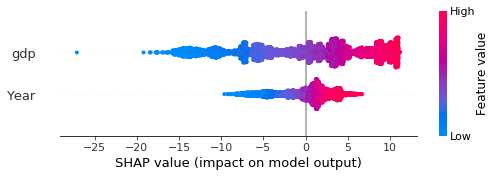

In [117]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x)

# summarize the effects of all the features
shap.summary_plot(shap_values, x)

Looking at the average of the shap impact per samples, we reiterate that both variables have a postive impact, but that gdp has a stronger impact.

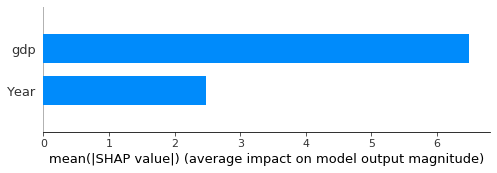

In [118]:
shap.summary_plot(shap_values, x, plot_type="bar")

The the default ols trendline in the scatter shows the relationship between gdp and life expectance is generally increasing (the year is overlayed as the hover-label). One important component of this analysis, particularly with linear regression, is autocorrelations between the same counteries over different years. The GDP and life expectancy will be inherantly correlated with the values of the prior years for countries, thereby causing autocorrelation. This highlights another advantage of using xgboost or other tree based methods; they are inherantly robust towards autocorrelation.

In [128]:
fig = px.scatter(gdp, x='gdp', y='life_expectancy_years', hover_name='Year', trendline="ols")

fig.layout.title.text = 'GDP vs. Life Expectancy'
fig.layout.xaxis.title = 'GDP'
fig.layout.yaxis.title = 'Life Expectancy'

fig.show()

# Problem 5

In [130]:
gdp = pd.read_csv(f'{gp}/ddf--datapoints--gdppercapita_us_inflation_adjusted--by--geo--time.csv').rename(columns={'gdppercapita_us_inflation_adjusted' : 'gdp'})
mortality = pd.read_csv(f'{gp}/ddf--datapoints--child_mortality_0_5_year_olds_more_years_version_7--by--geo--time.csv')

gdp = gdp.merge(mortality, how='left', on=['geo', 'time']).rename(columns={'name' : 'Country', 'time' : 'Year', 'gdp' : 'GDP',
                    'child_mortality_0_5_year_olds_more_years_version_7': 'Child Mortality'})
gdp = gdp[gdp['Child Mortality'].notnull()]

gdp.head()

,geo,Year,GDP,Child Mortality
1,afg,2002,364.57057,129.4
2,afg,2003,376.75871,125.9
3,afg,2004,364.09544,122.4
4,afg,2005,389.41636,119.0
5,afg,2006,397.98590,115.8


In [131]:
x = gdp[['GDP', 'Year']]
# x.GDP = x.GDP.apply(np.log)

y = gdp['Child Mortality']

**Once again I am evaluating two models: xgboost and logistic regression**

In [121]:
xgb = XGBRegressor()
xgb.fit(x, y)

lr = LinearRegression()
lr.fit(x, y)

C:\software\Anaconda3\envs\advanced\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\software\Anaconda3\envs\advanced\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[15:20:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Here we generally the same feature influce for gdp and year in xgboost, but now the gdp is less influential then year with linear regression without being in log space (the value becomes more influential than year if gdp is in log space).

In [122]:
print(xgb.feature_importances_)
print(lr.coef_)

[0.6429005  0.35709947]
[-2.10512684e-03 -2.11489967e+00]


While gdp seems to have a larger impact on shap values for child mortality for xgboost, the negative end of the spectrum is less consistant than for the extreem values of life expectancey (which we can see in the variety of colors). 

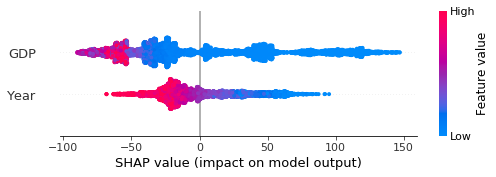

In [123]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x)

# summarize the effects of all the features
shap.summary_plot(shap_values, x)

In spite of the variability at the negative extreems for gdp, it clearly has a higher average impact on the shap values for samples.

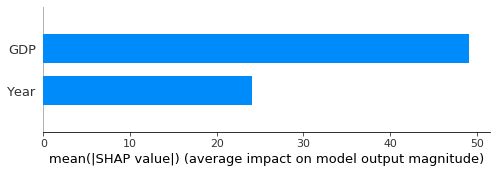

In [124]:
shap.summary_plot(shap_values, x, plot_type="bar")

Below we see the same ols fit for the scatter of all data points. This plot highlights another limitation of linear regression besides autocorrelation (the discussion of auto correlation from problem 4 also applies here), being that the model predicts a child mortality below 0. That prediction is impossible, as the 0 is the lowest value for any mortality rate. XGBoost is again a superier model because of stability and handling autocorrelation, but also because it can incorporate non-linear predictions.

In [132]:
fig = px.scatter(gdp, x='GDP', y='Child Mortality', hover_name='Year', trendline="ols")

fig.layout.title.text = 'GDP vs. Child Mortality'

fig.show()